# 多层神经网络

## 多层神经网络

线性回归中，公式是 $y = w x + b$

而在 Logistic 回归中，公式是 $y = Sigmoid(w x + b)$

其实它们都可以看成单层神经网络

## 神经网络的结构
神经网络就是很多个神经元堆在一起形成的一层神经网络，那么多个层堆叠在一起就是深层神经网络

神经网络的结构非常简单，主要有输入层，隐藏层，输出层构成

输入层需要根据特征数目来决定，输出层根据解决的问题来决定
隐藏层的网路层数以及每层的神经元数就是可以调节的参数，而不同的层数和每层的参数对模型的影响非常大

神经网络向前传播也非常简单，就是一层一层不断做运算就可以了，可以看看下面这个例子

## 为什么要使用激活函数
使用激活函数是非常必要的

比如一个两层的神经网络，使用 A 表示激活函数，那么

$$
y = w_2 A(w_1 x)
$$

如果不使用激活函数，那么神经网络的结果就是

$$
y = w_2 (w_1 x) = (w_2 w_1) x = \bar{w} x
$$

可以看到，将两层神经网络的参数合在一起，用 $\bar{w}$ 来表示，两层的神经网络其实就变成了一层神经网络，只不过参数变成了新的 $\bar{w}$

所以**如果不使用激活函数，那么不管多少层的神经网络，$y = w_n \cdots w_2 w_1 x = \bar{w} x$，就都变成了单层神经网络，所以在每一层我们都必须使用激活函数**

最后我们看看激活函数对神经网络的影响

![](https://ws1.sinaimg.cn/large/006tNc79ly1fmgkeqjr34g306r065diu.gif)

可以看到使用了激活函数之后，神经网络可以通过改变权重实现任意形状，越是复杂的神经网络能拟合的形状越复杂，这就是著名的神经网络万有逼近定理。

下面我们通过例子来感受一下神经网络的强大之处

In [1]:
import torch 
import numpy as np
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

创建一个打印决策边界的函数

In [2]:
def plot_decision_boundary(model,x,y):
    #设置最大值与最小值，再给他们一些padding
    x_min,x_max = x[:,0].min() - 1,x[:,0].max() + 1#最小值减了1，最大值加了1
    y_min,y_max = x[:,1].min() - 1,x[:,1].max() + 1#最小值减了1，最大值加了1
   
    h = 0.01#间距
    #生成一系列间距为h的点
    xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
    #预测整个网络的值
    Z = model(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    #绘制边界和训练集示例
    plt.contourf(xx,yy,Z, cmap = plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:,0],x[:,1],c=y.reshape(-1),s=40,cmap=plt.cm.Spectral)   

处理一个二分类问题，但是数据分布的比之前复杂

In [3]:
#生成鸢尾花数据
np.random.seed(1)
m = 400 # 样本数量
N = int(m/2) # 每一类的点的个数
D = 2 # 维度
x = np.zeros((m, D))
y = np.zeros((m, 1), dtype='uint8') # label 向量，0 表示红色，1 表示蓝色
a = 4

for j in range(2):
    ix = range(N*j,N*(j+1))
    t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

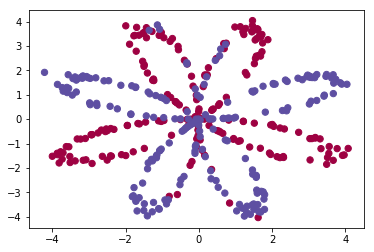

In [4]:
#打印数据
plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=40, cmap=plt.cm.Spectral)

先尝试用 logistic 回归来解决这个问题

In [5]:
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

In [6]:
#初始化参数
w = nn.Parameter(torch.randn(2,1))
b = nn.Parameter(torch.zeros(1))
#设置优化器
optimizer = torch.optim.SGD([w,b],1e-1)
#逻辑回归函数
def logistic_regression(x):
    return torch.mm(x,w) + b
#使用内置的逻辑回归Loss
criterion = nn.BCEWithLogitsLoss()

In [7]:
for e in range(100):
    #根据输入X预测结果
    out = logistic_regression(Variable(x))
    #根据逻辑回归的输出计算Loss
    loss = criterion(out,Variable(y))
    #清空梯度
    optimizer.zero_grad()
    #自动求导
    loss.backward()
    #更新参数
    optimizer.step()
    #每20次输出一次
    if (e+1) % 20 == 0:
        print('epoch:{},loss:{}'.format(e+1,loss.data[0]))    

epoch:20,loss:0.6930139660835266
epoch:40,loss:0.6736007332801819
epoch:60,loss:0.6731565594673157
epoch:80,loss:0.6731470227241516
epoch:100,loss:0.6731464266777039


In [8]:
#打印
def plot_logistic(x):
    x = Variable(torch.from_numpy(x).float())
    out = F.sigmoid(logistic_regression(x))
    out = (out > 0.5) *1
    return out.data.numpy()

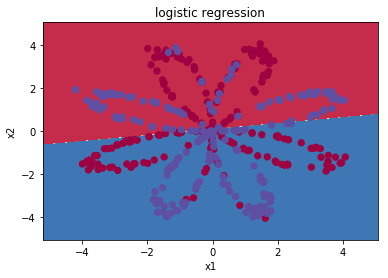

In [9]:
plot_decision_boundary(lambda x: plot_logistic(x), x.numpy(), y.numpy())
plt.title('logistic regression')

logistic 回归是一个线性分类器，并不能很好的区分开这个复杂的数据集，这个时候就该神经网络登场了！

In [11]:
#定义两层神经网络的参数
w1 = nn.Parameter(torch.randn(2,4) * 0.01)
b1 = nn.Parameter(torch.zeros(4))

w2 = nn.Parameter(torch.randn(4,1) * 0.01)
b2 = nn.Parameter(torch.zeros(1))

#定义模型
def two_network(x):
    x1 = torch.mm(x,w1) + b1
    x1 = F.tanh(x1)
    x2 = torch.mm(x1,w2) + b2
    return x2

optimizer = torch.optim.SGD([w1,w2,b1,b2],1.)

criterion = nn.BCEWithLogitsLoss()

In [12]:
#训练10000次
for e in range(10000):
    out = two_network(Variable(x))
    loss = criterion(out,Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e+1) % 1000 == 0:
        print('epoch:{},loss:{}'.format(e+1,loss.data[0]))

epoch:1000,loss:0.2920187711715698
epoch:2000,loss:0.2769234776496887
epoch:3000,loss:0.24369333684444427
epoch:4000,loss:0.23179687559604645
epoch:5000,loss:0.22633059322834015
epoch:6000,loss:0.22285111248493195
epoch:7000,loss:0.22030892968177795
epoch:8000,loss:0.21830981969833374
epoch:9000,loss:0.21667499840259552
epoch:10000,loss:0.21531403064727783


In [13]:
def plot_network(x):
    x = Variable(torch.from_numpy(x).float())
    x1 = torch.mm(x,w1) + b1
    x1 = F.tanh(x1)
    x2 = torch.mm(x1,w2) + b2
    out = F.sigmoid(x2)
    out = (out > 0.5) * 1
    return out.data.numpy()

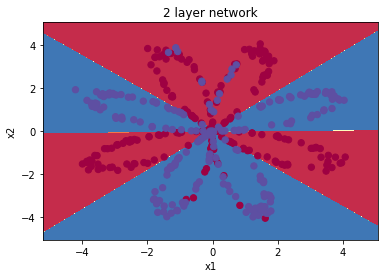

In [14]:
plot_decision_boundary(lambda x: plot_network(x),x.numpy(),y.numpy())
plt.title('2 layer network')

和前面的 logistic 回归相比，可以看到神经网络能够非常好地分类这个复杂的数据，神经网络因为有了激活函数的存在，成了一个非线性分类器，所以神经网络分类的边界更加复杂。